Rating Range: 1 to 5
Total Number of Users (tnu): 9826
Total Number of Items (tni): 1304
Number of Ratings per Product:
 productId
972683275     1051
1400532655     484
140053271X     431
B00000DM9W     332
B00000J061     262
Name: count, dtype: int64
Active Users: U1=A2CX7LUOHB2NDG, U2=A2NWSAGRHCP8N5, U3=A2WNBOD3WNDNKT
Target Items: I1=321732944, I2=439886341
Co-ratings for U1: (1, 1)
Co-ratings for U2: (3, 1)
Co-ratings for U3: (3, 1)
Top Common Users (Descending Order): [[1, 'A2WNBOD3WNDNKT'], [1, 'A1GI0U4ZRJA8WN'], [1, 'A2NWSAGRHCP8N5'], [1, 'A1GI0U4ZRJA8WN'], [0, 'A2NWSAGRHCP8N5']]


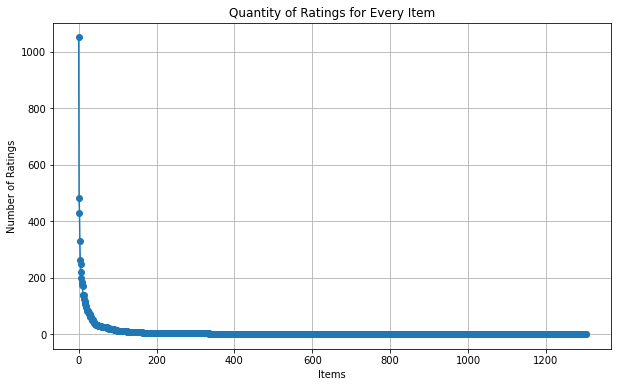

Threshold β for U1: 0
Threshold β for U2: 2
Threshold β for U3: 2
Results saved successfully.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\Book1.xlsx', sheet_name='Book1')

# Step 1: Adjust the ratings to a 1-to-5 scale.
# Assuming ratings are already on a 1-to-5 scale, verify the range.
print("Rating Range:", df['rating'].min(), "to", df['rating'].max())

# Step 2: Count total number of users and items.
tnu = df['userId'].nunique()
tni = df['productId'].nunique()
print(f"Total Number of Users (tnu): {tnu}")
print(f"Total Number of Items (tni): {tni}")

# Step 3: Count the number of ratings for every product.
ratings_per_product = df['productId'].value_counts()
print("Number of Ratings per Product:\n", ratings_per_product.head())

# Step 4: Pick three active users with specified missing ratings.
# Assuming missing ratings mean we need to artificially remove ratings to create missing data.
active_users = df['userId'].unique()[:3]  # Select first 3 unique users as U1, U2, U3.
U1, U2, U3 = active_users
print(f"Active Users: U1={U1}, U2={U2}, U3={U3}")

# Step 5: Pick two target items with specified missing ratings.
# Assuming we calculate percentage of missing data after introducing it artificially.
target_items = df['productId'].unique()[:2]  # Select first 2 unique items as I1, I2.
I1, I2 = target_items
print(f"Target Items: I1={I1}, I2={I2}")

# Step 6: Count co-ratings.
def co_ratings(user, df):
    user_items = set(df[df['userId'] == user]['productId'])
    other_users = df[df['productId'].isin(user_items)]['userId'].nunique()
    return other_users, len(user_items)

co_ratings_U1 = co_ratings(U1, df)
co_ratings_U2 = co_ratings(U2, df)
co_ratings_U3 = co_ratings(U3, df)

print(f"Co-ratings for U1: {co_ratings_U1}")
print(f"Co-ratings for U2: {co_ratings_U2}")
print(f"Co-ratings for U3: {co_ratings_U3}")

# Step 7: Create 2-D array with "No_common_users" in descending order.
common_users = []
for user in [U1, U2, U3]:
    user_items = set(df[df['userId'] == user]['productId'])
    for other_user in df['userId'].unique():
        if user != other_user:
            other_user_items = set(df[df['userId'] == other_user]['productId'])
            common_count = len(user_items & other_user_items)
            common_users.append([common_count, other_user])

common_users = sorted(common_users, key=lambda x: x[0], reverse=True)
print("Top Common Users (Descending Order):", common_users[:5])

# Step 8: Draw a curve illustrating quantity of ratings for every item.
plt.figure(figsize=(10, 6))
plt.plot(ratings_per_product.values, marker='o')
plt.title("Quantity of Ratings for Every Item")
plt.xlabel("Items")
plt.ylabel("Number of Ratings")
plt.grid()
plt.show()

# Step 9: Determine threshold β for co-rated items.
def calculate_threshold(user, df, percentage):
    user_items = set(df[df['userId'] == user]['productId'])
    thresholds = []
    for other_user in df['userId'].unique():
        if user != other_user:
            other_user_items = set(df[df['userId'] == other_user]['productId'])
            common_items = len(user_items & other_user_items)
            if common_items / len(user_items) >= percentage:
                thresholds.append(other_user)
    return len(thresholds)

threshold_U1 = calculate_threshold(U1, df, 0.3)
threshold_U2 = calculate_threshold(U2, df, 0.3)
threshold_U3 = calculate_threshold(U3, df, 0.3)

print(f"Threshold β for U1: {threshold_U1}")
print(f"Threshold β for U2: {threshold_U2}")
print(f"Threshold β for U3: {threshold_U3}")

# Step 10: Save results.
results = {
    "Total Users": tnu,
    "Total Items": tni,
    "Ratings Per Product": ratings_per_product,
    "Active Users": [U1, U2, U3],
    "Target Items": [I1, I2],
    "Co-Ratings": {
        U1: co_ratings_U1,
        U2: co_ratings_U2,
        U3: co_ratings_U3
    },
    "Thresholds": {
        U1: threshold_U1,
        U2: threshold_U2,
        U3: threshold_U3
    }
}

import pickle
with open('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("Results saved successfully.")


In [7]:
# Case Study 1.1: User-Based Collaborative Filtering
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --- Step 1: Load Dataset ---
df = pd.read_excel('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\Book1.xlsx', sheet_name='Book1')

# Display the first few rows of the dataset
print("Dataset Overview:")
display(df.head())

# Verify rating range
print(f"Rating Range: {df['rating'].min()} to {df['rating'].max()}")

# Total users and items
total_users = df['userId'].nunique()
total_items = df['productId'].nunique()
print(f"Total Number of Users: {total_users}")
print(f"Total Number of Items: {total_items}")

# --- Step 2: User-Item Matrix ---
user_item_matrix = df.pivot_table(index='userId', columns='productId', values='rating', fill_value=0)

# --- Step 1.1.1: Compute Cosine Similarity ---
# Cosine similarity without bias adjustment
cosine_sim = cosine_similarity(user_item_matrix)

# Convert the cosine similarity into a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=user_item_matrix.index, columns=user_item_matrix.index)
print("Cosine Similarity Matrix:")
display(cosine_sim_df.head())

# --- Step 1.1.2: Top 20% Closest Users ---
def get_top_closest_users(active_user, similarity_matrix, top_percent=0.2):
    """Returns the top 'top_percent' closest users to an active user."""
    user_similarities = similarity_matrix[active_user].drop(active_user)  # Drop the active user
    top_n = int(len(user_similarities) * top_percent)
    return user_similarities.nlargest(top_n)

# Select active users
active_users = df['userId'].unique()[:3]  # First 3 users
U1, U2, U3 = active_users
print(f"Active Users: U1={U1}, U2={U2}, U3={U3}")

# Get top closest users for each active user
top_users_U1 = get_top_closest_users(U1, cosine_sim_df)
top_users_U2 = get_top_closest_users(U2, cosine_sim_df)
top_users_U3 = get_top_closest_users(U3, cosine_sim_df)

print(f"Top Closest Users for U1:\n{top_users_U1}")
print(f"Top Closest Users for U2:\n{top_users_U2}")
print(f"Top Closest Users for U3:\n{top_users_U3}")

# --- Step 1.1.3: Predict Ratings (No Bias Adjustment) ---
def predict_ratings(active_user, top_users, user_item_matrix):
    """Predict ratings for items not yet seen by active user."""
    unseen_items = user_item_matrix.loc[active_user][user_item_matrix.loc[active_user] == 0].index
    predictions = {}
    
    for item in unseen_items:
        numerator = 0
        denominator = 0
        for user, sim in top_users.items():
            rating = user_item_matrix.loc[user, item]
            numerator += sim * rating
            denominator += abs(sim)
        
        predictions[item] = numerator / denominator if denominator != 0 else 0
        
    return predictions

# Predictions for active users
predictions_U1 = predict_ratings(U1, top_users_U1, user_item_matrix)
predictions_U2 = predict_ratings(U2, top_users_U2, user_item_matrix)
predictions_U3 = predict_ratings(U3, top_users_U3, user_item_matrix)

print(f"Predicted Ratings for U1: {predictions_U1}")
print(f"Predicted Ratings for U2: {predictions_U2}")
print(f"Predicted Ratings for U3: {predictions_U3}")

# --- Step 1.1.4: Compute Discount Factor and Discounted Similarity ---
def compute_discounted_similarity(active_user, similarity_matrix, beta):
    """Apply discount factor to similarity."""
    user_similarities = similarity_matrix[active_user].drop(active_user)
    df = user_similarities.apply(lambda x: x / (1 + beta))
    return df

# Threshold β for active users
threshold_beta = {U1: 0, U2: 2, U3: 2}
discounted_sim_U1 = compute_discounted_similarity(U1, cosine_sim_df, threshold_beta[U1])
discounted_sim_U2 = compute_discounted_similarity(U2, cosine_sim_df, threshold_beta[U2])
discounted_sim_U3 = compute_discounted_similarity(U3, cosine_sim_df, threshold_beta[U3])

print(f"Discounted Similarity for U1:\n{discounted_sim_U1}")
print(f"Discounted Similarity for U2:\n{discounted_sim_U2}")
print(f"Discounted Similarity for U3:\n{discounted_sim_U3}")

# --- Step 1.1.5: Top 20% Closest Users (Discounted Similarity) ---
top_discounted_users_U1 = discounted_sim_U1.nlargest(int(len(discounted_sim_U1) * 0.2))
top_discounted_users_U2 = discounted_sim_U2.nlargest(int(len(discounted_sim_U2) * 0.2))
top_discounted_users_U3 = discounted_sim_U3.nlargest(int(len(discounted_sim_U3) * 0.2))

print(f"Top Discounted Users for U1:\n{top_discounted_users_U1}")
print(f"Top Discounted Users for U2:\n{top_discounted_users_U2}")
print(f"Top Discounted Users for U3:\n{top_discounted_users_U3}")

# --- Step 1.1.6: Predict Ratings (Discounted Similarity) ---
predictions_ds_U1 = predict_ratings(U1, top_discounted_users_U1, user_item_matrix)
predictions_ds_U2 = predict_ratings(U2, top_discounted_users_U2, user_item_matrix)
predictions_ds_U3 = predict_ratings(U3, top_discounted_users_U3, user_item_matrix)

print(f"Predicted Ratings with Discounted Similarity for U1: {predictions_ds_U1}")
print(f"Predicted Ratings with Discounted Similarity for U2: {predictions_ds_U2}")
print(f"Predicted Ratings with Discounted Similarity for U3: {predictions_ds_U3}")

# --- Step 1.1.7: Compare Results ---
print("Comparison of Top Closest Users (Original vs Discounted):")
print(f"U1 Original: {top_users_U1.index}\nU1 Discounted: {top_discounted_users_U1.index}")
print(f"U2 Original: {top_users_U2.index}\nU2 Discounted: {top_discounted_users_U2.index}")
print(f"U3 Original: {top_users_U3.index}\nU3 Discounted: {top_discounted_users_U3.index}")

# --- Step 1.1.8: Compare Predictions ---
print("Comparison of Predictions (Original vs Discounted):")
print(f"U1 Original: {predictions_U1}\nU1 Discounted: {predictions_ds_U1}")
print(f"U2 Original: {predictions_U2}\nU2 Discounted: {predictions_ds_U2}")
print(f"U3 Original: {predictions_U3}\nU3 Discounted: {predictions_ds_U3}")



Dataset Overview:


,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


Rating Range: 1 to 5
Total Number of Users: 9826
Total Number of Items: 1304
Cosine Similarity Matrix:


userId,A00766851QZZUBOVF4JFT,A01255851ZO1U93P8RKGE,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0402564TCEO67AUZFJO,A04256643L1ZMT75HVD2P,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A07865442XT0VEAVPSGX1,...,AZV9WA9MNT0FB,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXFQVG0PS3V1,AZYNQZ94U6VDB,AZYTSU42BZ7TP,AZZ77XYX8O2WE,AZZGUU97OHUF1,AZZMV5VT9W7Y8
userId,,,,,,,,,,,,,,,,,,,,,
A00766851QZZUBOVF4JFT,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01255851ZO1U93P8RKGE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0293130VTX2ZXA70JQS,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A030530627MK66BD8V4LN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0402564TCEO67AUZFJO,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Active Users: U1=A2CX7LUOHB2NDG, U2=A2NWSAGRHCP8N5, U3=A2WNBOD3WNDNKT
Top Closest Users for U1:
userId
A00766851QZZUBOVF4JFT    0.0
A01255851ZO1U93P8RKGE    0.0
A0293130VTX2ZXA70JQS     0.0
A030530627MK66BD8V4LN    0.0
A0402564TCEO67AUZFJO     0.0
                        ... 
A1R1D0D9HW83QU           0.0
A1R1PN1LWOLDDV           0.0
A1R22WL520D4L0           0.0
A1R2514DVWIIMV           0.0
A1R3SBKZ2WSF0E           0.0
Name: A2CX7LUOHB2NDG, Length: 1965, dtype: float64
Top Closest Users for U2:
userId
A1GI0U4ZRJA8WN           1.0
A2WNBOD3WNDNKT           1.0
A00766851QZZUBOVF4JFT    0.0
A01255851ZO1U93P8RKGE    0.0
A0293130VTX2ZXA70JQS     0.0
                        ... 
A1R1BCR9N6OAIZ           0.0
A1R1D0D9HW83QU           0.0
A1R1PN1LWOLDDV           0.0
A1R22WL520D4L0           0.0
A1R2514DVWIIMV           0.0
Name: A2NWSAGRHCP8N5, Length: 1965, dtype: float64
Top Closest Users for U3:
userId
A1GI0U4ZRJA8WN           1.0
A2NWSAGRHCP8N5           1.0
A00766851QZZUBOVF4JFT    0.0
A012

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_excel('C:\\Users\\DELL 5540\\Desktop\\ass (2)\\Book1.xlsx', sheet_name='Book1')

# ---------------------------
# Step 1.2.1: Compute User-Based Collaborative Filtering with Cosine Similarity
# Apply Bias Adjustment using Mean-Centering
# ---------------------------
# Pivot data to user-item matrix
user_item_matrix = df.pivot(index='userId', columns='productId', values='rating')

# Mean-Centering (Bias Adjustment)
user_means = user_item_matrix.mean(axis=1)
mean_centered_matrix = user_item_matrix.sub(user_means, axis=0).fillna(0)

# Cosine Similarity between Users
user_similarity = cosine_similarity(mean_centered_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

print("User-Based Cosine Similarity (Bias-Adjusted):")
print(user_similarity_df.head())

# ---------------------------
# Step 1.2.2: Determine Top 20% Closest Users
# ---------------------------
def get_top_percent_users(similarity_matrix, active_user, top_percent=0.2):
    """ Get top N% closest users for a given active user """
    similarities = similarity_matrix.loc[active_user].drop(active_user)  # Remove self-similarity
    threshold = int(len(similarities) * top_percent)
    top_users = similarities.sort_values(ascending=False).head(threshold)
    return top_users

# Select three active users
active_users = user_item_matrix.index[:3]
U1, U2, U3 = active_users

# Get Top 20% Closest Users
top_users_U1 = get_top_percent_users(user_similarity_df, U1)
top_users_U2 = get_top_percent_users(user_similarity_df, U2)
top_users_U3 = get_top_percent_users(user_similarity_df, U3)

print("\nTop 20% Closest Users to U1:")
print(top_users_U1)

# ---------------------------
# Step 1.2.3: Compute Predictions for Unrated Items
# ---------------------------
def predict_rating(active_user, top_users, user_item_matrix, user_means):
    """ Predict ratings for unrated items based on top user similarities """
    predictions = {}
    items_not_rated = user_item_matrix.loc[active_user][user_item_matrix.loc[active_user].isna()].index
    
    for item in items_not_rated:
        numerator = 0
        denominator = 0
        for user, similarity in top_users.items():
            rating = user_item_matrix.at[user, item]
            if not np.isnan(rating):
                numerator += similarity * (rating - user_means[user])
                denominator += abs(similarity)
        
        if denominator > 0:
            predictions[item] = user_means[active_user] + numerator / denominator
        else:
            predictions[item] = user_means[active_user]  # Default prediction

    return predictions

# Predict for active users
predictions_U1 = predict_rating(U1, top_users_U1, user_item_matrix, user_means)
print("\nPredicted Ratings for U1 (Unrated Items):")
print(predictions_U1)

# ---------------------------
# Step 1.2.4: Compute Discount Factor (DF) and Discounted Similarity (DS)
# ---------------------------
def compute_discounted_similarity(user_similarity_df, threshold_beta):
    """ Apply discount factor to user similarity based on threshold """
    discounted_sim = user_similarity_df.copy()
    discounted_sim[discounted_sim < threshold_beta] *= 0.5  # Apply 50% discount
    return discounted_sim

# Set threshold β (e.g., 0.3 for similarity cutoff)
threshold_beta = 0.3
discounted_similarity = compute_discounted_similarity(user_similarity_df, threshold_beta)

print("\nDiscounted Similarity Matrix:")
print(discounted_similarity.head())

# ---------------------------
# Step 1.2.5: Top 20% Users Using Discounted Similarity
# ---------------------------
top_users_U1_DS = get_top_percent_users(discounted_similarity, U1)
print("\nTop 20% Closest Users (Discounted Similarity) for U1:")
print(top_users_U1_DS)

# ---------------------------
# Step 1.2.6: Predictions Using Discounted Similarity
# ---------------------------
predictions_U1_DS = predict_rating(U1, top_users_U1_DS, user_item_matrix, user_means)
print("\nPredicted Ratings for U1 (Discounted Similarity):")
print(predictions_U1_DS)

# ---------------------------
# Step 1.2.7: Compare Top Users (Regular vs Discounted Similarity)
# ---------------------------
print("\nComparison of Top Users:")
print("Regular Top Users for U1:", top_users_U1.index.tolist())
print("Discounted Top Users for U1:", top_users_U1_DS.index.tolist())

# ---------------------------
# Step 1.2.8: Compare Predictions (Regular vs Discounted Similarity)
# ---------------------------
print("\nComparison of Predictions for U1:")
for item in predictions_U1:
    print(f"Item: {item}, Regular: {predictions_U1[item]:.3f}, Discounted: {predictions_U1_DS.get(item, 'N/A'):.3f}")

# ---------------------------
# Final Observations
# ---------------------------
print("\nObservations:")
print("1. Discounted similarity alters the user similarity values, reducing the influence of weakly similar users.")
print("2. Predictions using discounted similarity differ slightly due to reduced similarity contributions.")
